In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
from collections import defaultdict

In [2]:
# Đọc file CSV
df = pd.read_csv('f_coco_triplets.csv')

# Lấy danh sách unique entity và relation
entities = pd.unique(df[['subject', 'object']].values.ravel())
relations = df['predicate'].unique()

# Tạo ánh xạ từ tên → ID
entity2id = {e: i for i, e in enumerate(entities)}
relation2id = {r: i for i, r in enumerate(relations)}

# Chuyển dataframe về dạng (head_id, rel_id, tail_id)
triplets = df.apply(lambda row: [entity2id[row['subject']], relation2id[row['predicate']], entity2id[row['object']]], axis=1)
triplets = np.array(list(triplets))

# Chuyển về dạng ID
df["head_id"] = df["subject"].map(entity2id)
df["relation_id"] = df["predicate"].map(relation2id)
df["tail_id"] = df["object"].map(entity2id)
triplets = df[["head_id", "relation_id", "tail_id"]].values

In [3]:
class TransE(nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim=300, margin=1.0):
        super().__init__()
        self.margin = margin
        self.ent_embeddings = nn.Embedding(num_entities, embedding_dim)
        self.rel_embeddings = nn.Embedding(num_relations, embedding_dim)
        nn.init.xavier_uniform_(self.ent_embeddings.weight.data)
        nn.init.xavier_uniform_(self.rel_embeddings.weight.data)

    def forward(self, pos_triples, neg_triples):
        pos_h = self.ent_embeddings(pos_triples[:, 0])
        pos_r = self.rel_embeddings(pos_triples[:, 1])
        pos_t = self.ent_embeddings(pos_triples[:, 2])
        neg_h = self.ent_embeddings(neg_triples[:, 0])
        neg_r = self.rel_embeddings(neg_triples[:, 1])
        neg_t = self.ent_embeddings(neg_triples[:, 2])
        pos_score = torch.norm(pos_h + pos_r - pos_t, p=2, dim=1)
        neg_score = torch.norm(neg_h + neg_r - neg_t, p=2, dim=1)
        return pos_score, neg_score

In [4]:
def corrupt_batch(batch, num_entities):
    corrupted = []
    for h, r, t in batch:
        if random.random() < 0.5:
            corrupted.append([random.randint(0, num_entities-1), r, t])
        else:
            corrupted.append([h, r, random.randint(0, num_entities-1)])
    return corrupted


In [5]:
import torch
import numpy as np
import torch.nn as nn

def train_transe(model, train_data, num_entities, num_epochs=300, batch_size=512, lr=0.001, patience=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MarginRankingLoss(margin=model.margin)
    best_loss = float('inf'); wait = 0
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        np.random.shuffle(train_data)
        for i in range(0, len(train_data), batch_size):
            batch_pos = train_data[i:i+batch_size]
            batch_neg = corrupt_batch(batch_pos, num_entities)
            batch_pos = torch.tensor(batch_pos, dtype=torch.long)
            batch_neg = torch.tensor(batch_neg, dtype=torch.long)
            y = torch.ones(batch_pos.size(0))
            pos_score, neg_score = model(batch_pos, batch_neg)
            loss = criterion(pos_score, neg_score, y)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / (len(train_data) / batch_size)
        print(f"Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}")
        if avg_loss < best_loss:
            best_loss = avg_loss
            wait = 0
            torch.save(model.state_dict(), "best_transe_model.pth")
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping.")
                break

In [6]:
# Huấn luyện
model = TransE(len(entities), len(relations), embedding_dim=300)
train_transe(model, triplets, len(entities))

Epoch 1 | Avg Loss: 1.0652
Epoch 2 | Avg Loss: 1.0108
Epoch 3 | Avg Loss: 0.9583
Epoch 4 | Avg Loss: 0.9057
Epoch 5 | Avg Loss: 0.8496
Epoch 6 | Avg Loss: 0.7935
Epoch 7 | Avg Loss: 0.7404
Epoch 8 | Avg Loss: 0.6944
Epoch 9 | Avg Loss: 0.6302
Epoch 10 | Avg Loss: 0.5816
Epoch 11 | Avg Loss: 0.5404
Epoch 12 | Avg Loss: 0.5061
Epoch 13 | Avg Loss: 0.4741
Epoch 14 | Avg Loss: 0.4559
Epoch 15 | Avg Loss: 0.4434
Epoch 16 | Avg Loss: 0.4054
Epoch 17 | Avg Loss: 0.3984
Epoch 18 | Avg Loss: 0.3905
Epoch 19 | Avg Loss: 0.3666
Epoch 20 | Avg Loss: 0.3744
Epoch 21 | Avg Loss: 0.3456
Epoch 22 | Avg Loss: 0.3536
Epoch 23 | Avg Loss: 0.3337
Epoch 24 | Avg Loss: 0.3243
Epoch 25 | Avg Loss: 0.3218
Epoch 26 | Avg Loss: 0.3116
Epoch 27 | Avg Loss: 0.3066
Epoch 28 | Avg Loss: 0.2912
Epoch 29 | Avg Loss: 0.2942
Epoch 30 | Avg Loss: 0.2813
Epoch 31 | Avg Loss: 0.2815
Epoch 32 | Avg Loss: 0.2839
Epoch 33 | Avg Loss: 0.2631
Epoch 34 | Avg Loss: 0.2611
Epoch 35 | Avg Loss: 0.2601
Epoch 36 | Avg Loss: 0.2633
E

In [36]:
# Giả sử bạn đã có entity2id và relation2id
import pandas as pd

# Đọc dữ liệu triplet từ file hoặc DataFrame hiện có
df_triplet = pd.read_csv("f_coco_triplets.csv")  # hoặc thay bằng DataFrame bạn có

# Ánh xạ thành ID
df_triplet["head_id"] = df_triplet["subject"].map(entity2id)
df_triplet["relation_id"] = df_triplet["predicate"].map(relation2id)
df_triplet["tail_id"] = df_triplet["object"].map(entity2id)

# Kiểm tra
print(df_triplet[["subject", "predicate", "object", "head_id", "relation_id", "tail_id"]].head())

     subject predicate  object  head_id  relation_id  tail_id
0        man      wear     hat        0            0        1
1  telephone      have  banana        2            1        3
2      group     drive    tree        4            2        5
3        man     enjoy     nap        0            3        6
4        man      wear     hat        0            0        1


In [37]:
# Nếu đang có DataFrame:
triplets = df_triplet[["head_id", "relation_id", "tail_id"]].values  # lấy 3 cột dạng numpy

# Huấn luyện
train_transe(model, triplets, num_entities, num_epochs=300, batch_size=512, lr=0.001, patience=10)

Epoch 1 | Avg Loss: 1.0616
Epoch 2 | Avg Loss: 1.0074
Epoch 3 | Avg Loss: 0.9520
Epoch 4 | Avg Loss: 0.8976
Epoch 5 | Avg Loss: 0.8469
Epoch 6 | Avg Loss: 0.7892
Epoch 7 | Avg Loss: 0.7312
Epoch 8 | Avg Loss: 0.6742
Epoch 9 | Avg Loss: 0.6265
Epoch 10 | Avg Loss: 0.5932
Epoch 11 | Avg Loss: 0.5447
Epoch 12 | Avg Loss: 0.5090
Epoch 13 | Avg Loss: 0.4780
Epoch 14 | Avg Loss: 0.4491
Epoch 15 | Avg Loss: 0.4376
Epoch 16 | Avg Loss: 0.4150
Epoch 17 | Avg Loss: 0.3937
Epoch 18 | Avg Loss: 0.3848
Epoch 19 | Avg Loss: 0.3791
Epoch 20 | Avg Loss: 0.3652
Epoch 21 | Avg Loss: 0.3543
Epoch 22 | Avg Loss: 0.3430
Epoch 23 | Avg Loss: 0.3314
Epoch 24 | Avg Loss: 0.3208
Epoch 25 | Avg Loss: 0.3091
Epoch 26 | Avg Loss: 0.3075
Epoch 27 | Avg Loss: 0.3017
Epoch 28 | Avg Loss: 0.2934
Epoch 29 | Avg Loss: 0.2938
Epoch 30 | Avg Loss: 0.2887
Epoch 31 | Avg Loss: 0.2795
Epoch 32 | Avg Loss: 0.2749
Epoch 33 | Avg Loss: 0.2794
Epoch 34 | Avg Loss: 0.2573
Epoch 35 | Avg Loss: 0.2468
Epoch 36 | Avg Loss: 0.2497
E

In [7]:
import pandas as pd
from sklearn.preprocessing import normalize

# Xuất vector
entity_embeddings = model.ent_embeddings.weight.detach().cpu().numpy()
relation_embeddings = model.rel_embeddings.weight.detach().cpu().numpy()

# Chuẩn hóa
entity_embeddings = normalize(entity_embeddings)
relation_embeddings = normalize(relation_embeddings)

# Lưu ra file CSV
id2entity = {v: k for k, v in entity2id.items()}
id2relation = {v: k for k, v in relation2id.items()}
entity_df = pd.DataFrame(entity_embeddings)
entity_df.insert(0, "entity", [id2entity[i] for i in range(len(id2entity))])
entity_df.to_csv("entity_embeddings.csv", index=False)
relation_df = pd.DataFrame(relation_embeddings)
relation_df.insert(0, "relation", [id2relation[i] for i in range(len(id2relation))])
relation_df.to_csv("relation_embeddings.csv", index=False)

In [9]:
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from tqdm import tqdm

entity_df = pd.read_csv("entity_embeddings.csv")
relation_df = pd.read_csv("relation_embeddings.csv")
entity2vec = {row['entity']: row[1:].values for _, row in entity_df.iterrows()}
relation2vec = {row['relation']: row[1:].values for _, row in relation_df.iterrows()}

# all_map: dataframe gồm subject, predicate, object, image_id
all_map = df[['subject', 'predicate', 'object', 'image_id']].copy()

# Tạo vector ảnh từ object
image_vectors = {}
for img_id in all_map['image_id'].unique():
    rows = all_map[all_map['image_id'] == img_id]
    vecs = [entity2vec[o] for o in rows['object'] if o in entity2vec]
    if vecs:
        image_vectors[str(img_id)] = normalize([np.mean(vecs, axis=0)])[0]

# Tạo ground-truth
gt_dict = defaultdict(set)
for _, row in all_map.iterrows():
    gt_dict[(row['subject'], row['predicate'], row['object'])].add(str(row['image_id']))

# Hàm truy vấn và đánh giá
def get_query_embedding(s, r, o):
    if s not in entity2vec or r not in relation2vec or o not in entity2vec:
        return None
    return normalize([entity2vec[s] + relation2vec[r] - entity2vec[o]])[0]

def find_top_k_images(query, top_k=5):
    vec = get_query_embedding(*query)
    if vec is None:
        return []
    sims = [(img_id, cosine_similarity([vec], [img_vec])[0][0]) for img_id, img_vec in image_vectors.items()]
    return sorted(sims, key=lambda x: x[1], reverse=True)[:top_k]

def evaluate_query(query, top_k=5):
    predicted = {img_id for img_id, _ in find_top_k_images(query, top_k)}
    true = gt_dict.get(query, set())
    if not true:
        return None
    tp = len(predicted & true)
    fp = len(predicted - true)
    fn = len(true - predicted)
    precision = tp / (tp + fp) if tp + fp else 0
    recall = tp / (tp + fn) if tp + fn else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall else 0
    return precision, recall, f1

# Đánh giá trên 500 truy vấn
queries = all_map.drop_duplicates(subset=["subject", "predicate", "object"]).sample(50, random_state=42)
p_sum, r_sum, f1_sum, count = 0, 0, 0, 0
for _, row in tqdm(queries.iterrows(), total=len(queries)):
    result = evaluate_query((row["subject"], row["predicate"], row["object"]))
    if result:
        p, r, f1 = result
        p_sum += p; r_sum += r; f1_sum += f1
        count += 1

if count > 0:
    print(f"→ Precision@5: {p_sum / count:.4f}")
    print(f"→ Recall@5:    {r_sum / count:.4f}")
    print(f"→ F1-score@5:  {f1_sum / count:.4f}")
else:
    print("Không có truy vấn nào có ground truth.")

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.50it/s]

→ Precision@5: 0.0000
→ Recall@5:    0.0000
→ F1-score@5:  0.0000


In [10]:
import matplotlib.pyplot as plt
from PIL import Image
import os


# Hàm: từ triplet → hiển thị ảnh
def visualize_query_result(query, top_k=5, image_folder="E:/Download/val2017"):
    results = find_top_k_images(query, top_k)
    if not results:
        print("Không tìm thấy ảnh phù hợp.")
        return
    
    print(f"Truy vấn: ({query[0]} - {query[1]} - {query[2]})")
    print("Top ảnh liên quan:")
    
    plt.figure(figsize=(15, 3))
    for i, (img_id, score) in enumerate(results):
        image_path = os.path.join(image_folder, f"{int(img_id):012d}.jpg")
        if not os.path.exists(image_path):
            print(f"Không tìm thấy file ảnh: {image_path}")
            continue

        img = Image.open(image_path)
        plt.subplot(1, top_k, i + 1)
        plt.imshow(img)
        plt.title(f"{img_id}\nScore: {score:.2f}")
        plt.axis('off')
    plt.show()

Truy vấn: (teddy - bear - cake)
Top ảnh liên quan:


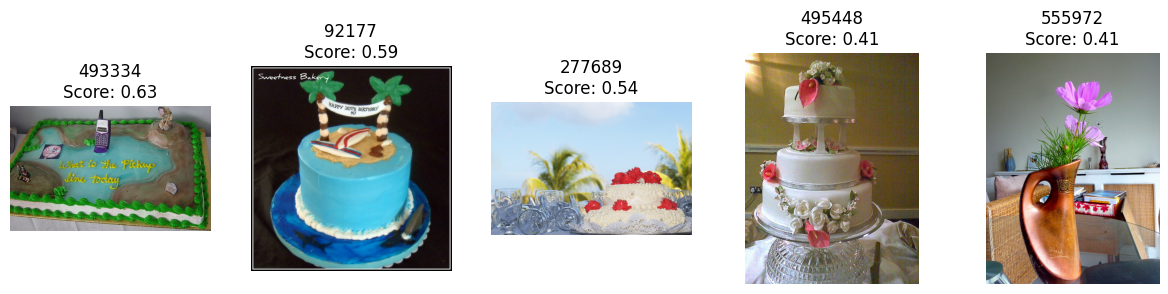

In [13]:
# Chọn 1 truy vấn minh họa từ file all_map
sample = all_map.sample(1).iloc[0]
query = (sample['subject'], sample['predicate'], sample['object'])

# Hiển thị kết quả truy vấn
visualize_query_result(query, top_k=5)

In [15]:
import os
import pickle
import numpy as np
import torch

# Tạo thư mục
output_dir = "saved_model_TransE"
os.makedirs(output_dir, exist_ok=True)

# 1. Lưu entity2id
with open(os.path.join(output_dir, "entity2id.pkl"), "wb") as f:
    pickle.dump(entity2id, f)

# 2. Lưu relation2id
with open(os.path.join(output_dir, "relation2id.pkl"), "wb") as f:
    pickle.dump(relation2id, f)

# 3. Lưu embedding vectors (numpy)
np.save(os.path.join(output_dir, "entity_embeddings.npy"), entity_embeddings)
np.save(os.path.join(output_dir, "relation_embeddings.npy"), relation_embeddings)

# 4. Lưu mô hình đã huấn luyện (chỉ trọng số)
torch.save(model.state_dict(), os.path.join(output_dir, "transe_model_weights.pt"))

print("Đã lưu entity2id, relation2id, embedding vectors và trọng số mô hình TransE.")


Đã lưu entity2id, relation2id, embedding vectors và trọng số mô hình TransE.


In [16]:
from collections import defaultdict
import pickle
import os

# Tạo thư mục nếu chưa có
os.makedirs("saved_model_TransE", exist_ok=True)

# Tạo ánh xạ entity_id → danh sách ảnh
entity_idx_to_images = defaultdict(set)

for _, row in all_map.iterrows():
    s = row["subject"]
    o = row["object"]
    img_id = row["image_id"]

    if s in entity2id:
        s_id = entity2id[s]
        entity_idx_to_images[s_id].add(img_id)
    if o in entity2id:
        o_id = entity2id[o]
        entity_idx_to_images[o_id].add(img_id)

# Lưu lại vào file pkl
with open("saved_model_TransE/entity_idx_to_images.pkl", "wb") as f:
    pickle.dump(entity_idx_to_images, f)

print("Đã lưu entity_idx_to_images.pkl vào saved_model_TransE/")

Đã lưu entity_idx_to_images.pkl vào saved_model_TransE/


In [39]:
import pandas as pd
import numpy as np

entity_df = pd.read_csv("entity_embeddings.csv")
relation_df = pd.read_csv("relation_embeddings.csv")

# Tạo từ điển ánh xạ
entity2vec = {row['entity']: row[1:].values for _, row in entity_df.iterrows()}
relation2vec = {row['relation']: row[1:].values for _, row in relation_df.iterrows()}

In [40]:
from sklearn.preprocessing import normalize

# Chuẩn hóa vector trước khi tính similarity
entity_df.iloc[:, 1:] = normalize(entity_df.iloc[:, 1:], axis=1)
relation_df.iloc[:, 1:] = normalize(relation_df.iloc[:, 1:], axis=1)

# Cập nhật lại dictionary
entity2vec = {row['entity']: row[1:].values for _, row in entity_df.iterrows()}
relation2vec = {row['relation']: row[1:].values for _, row in relation_df.iterrows()}

# Hàm tính embedding truy vấn: s + r - o
def get_query_embedding(subject, predicate, obj=None):
    s_vec = entity2vec.get(subject)
    r_vec = relation2vec.get(predicate)
    o_vec = entity2vec.get(obj) if obj else None
    if s_vec is None or r_vec is None:
        return None
    if o_vec is not None:
        return normalize([(s_vec + r_vec - o_vec)])[0]
    else:
        return normalize([(s_vec + r_vec)])[0]

In [41]:
# all_map chứa thông tin (subject, predicate, object, image_id)
image_vectors = {}
for img_id in all_map['image_id'].unique():
    triplets = all_map[all_map['image_id'] == img_id]
    vecs = []
    for _, row in triplets.iterrows():
        o_vec = entity2vec.get(row['object'])
        if o_vec is not None:
            vecs.append(o_vec)
    if vecs:
        avg_vec = np.mean(vecs, axis=0)
        image_vectors[str(img_id)] = normalize([avg_vec])[0]

In [42]:
from sklearn.metrics.pairwise import cosine_similarity

def find_nearest_image_from_query(query, top_k=5):
    subj, pred, obj = query
    q_vec = get_query_embedding(subj, pred, obj)  # thêm object
    if q_vec is None:
        return []

    similarities = []
    for img_id, img_vec in image_vectors.items():
        sim = cosine_similarity([q_vec], [img_vec])[0][0]
        similarities.append((img_id, sim))
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_k]

In [43]:
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm import tqdm

# Tạo từ điển ánh xạ triplet → danh sách image_id chứa triplet đó
gt_dict = defaultdict(set)
for _, row in all_map.iterrows():
    key = (row["subject"], row["predicate"], row["object"])
    gt_dict[key].add(str(row["image_id"]))

# Hàm lấy vector truy vấn s + r
def get_query_embedding(subject, predicate):
    s_vec = entity2vec.get(subject)
    r_vec = relation2vec.get(predicate)
    if s_vec is None or r_vec is None:
        return None
    return s_vec + r_vec

# Hàm tìm các ảnh gần nhất
def find_nearest_image_from_query(query, top_k=5):
    subj, pred, obj = query
    q_vec = get_query_embedding(subj, pred)
    if q_vec is None:
        return []

    similarities = []
    for img_id, img_vec in image_vectors.items():
        sim = cosine_similarity([q_vec], [img_vec])[0][0]
        similarities.append((img_id, sim))
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_k]

# Hàm đánh giá 1 truy vấn
def evaluate_single_triplet(query, top_k=5):
    results = find_nearest_image_from_query(query, top_k)
    predicted_ids = {str(img_id) for img_id, _ in results}
    true_ids = gt_dict.get(query, set())

    if not true_ids:
        return None  # bỏ qua nếu không có ground truth

    tp = len(predicted_ids & true_ids)
    fp = len(predicted_ids - true_ids)
    fn = len(true_ids - predicted_ids)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall    = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

# Chạy đánh giá trên 500 truy vấn
test_queries = all_map.drop_duplicates(subset=["subject", "predicate", "object"]).sample(500, random_state=42)

total_p, total_r, total_f1 = 0, 0, 0
count = 0

for _, row in tqdm(test_queries.iterrows(), total=len(test_queries)):
    query = (row["subject"], row["predicate"], row["object"])
    result = evaluate_single_triplet(query, top_k=5)
    if result:
        p, r, f1 = result
        total_p += p
        total_r += r
        total_f1 += f1
        count += 1

if count > 0:
    print("Evaluation Results (top-5):")
    print(f"→ Precision@5: {total_p/count:.4f}")
    print(f"→ Recall@5:    {total_r/count:.4f}")
    print(f"→ F1-score@5:  {total_f1/count:.4f}")
else:
    print("Không có truy vấn nào có ground-truth")


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [05:04<00:00,  1.64it/s]

Evaluation Results (top-5):
→ Precision@5: 0.0008
→ Recall@5:    0.0040
→ F1-score@5:  0.0013


In [ ]:
# chạy thử